In [1]:
import numpy as np
import time
import sys
import os
import tqdm

import torch
from torch import nn
import torch.nn.functional as F


from catr.configuration import Config
from catr.models.utils import NestedTensor, nested_tensor_from_tensor_list, get_rank
from catr.models.backbone import build_backbone
from catr.models.transformer import build_transformer
from catr.models.position_encoding import PositionEmbeddingSine
from catr.models.caption import MLP

import json

from dataset.dataset import ImageFeatureDataset
from torch.utils.data import DataLoader
from transformer_ethan import *
sys.path.append(os.path.join(os.path.dirname("__file__"), "catr"))
from engine import train_one_epoch, evaluate

In [2]:
words = np.load("glove_embed.npy")
with open('word2ind.json') as json_file: 
    word2ind = json.load(json_file) 
with open('ind2word.json') as json_file: 
    ind2word = json.load(json_file) 
config = Config()
config.device = 'cpu' # if running without GPU
config.feature_dim = 1024
config.pad_token_id = word2ind["<S>"]
config.hidden_dim = 300
config.nheads = 10
config.batch_size = 8
config.vocab_size = words.shape[0]
config.dir = '../mimic_features'
config.__dict__["pre_embed"] = torch.from_numpy(words)

In [3]:
model, criterion = main(config)
model = model.float()
device = torch.device(config.device)
model.to(device)

Initializing Device: cpu
Number of params: 33908144


Xray_Captioner(
  (input_proj): Conv2d(1024, 300, kernel_size=(1, 1), stride=(1, 1))
  (position_embedding): PositionEmbeddingSine()
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=300, out_features=300, bias=True)
          )
          (linear1): Linear(in_features=300, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=300, bias=True)
          (norm1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=3

In [4]:
param_dicts = [
        {"params": [p for n, p in model.named_parameters(
        ) if "backbone" not in n and p.requires_grad]},
        {
            "params": [p for n, p in model.named_parameters() if "backbone" in n and p.requires_grad],
            "lr": config.lr_backbone,
        },
    ]

In [5]:
optimizer = torch.optim.AdamW(
        param_dicts, lr=config.lr, weight_decay=config.weight_decay)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, config.lr_drop)

In [6]:
dataset_train = ImageFeatureDataset(config, mode='train')
dataset_val = ImageFeatureDataset(config, mode='val')

sampler_train = torch.utils.data.RandomSampler(dataset_train)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

batch_sampler_train = torch.utils.data.BatchSampler(
        sampler_train, config.batch_size, drop_last=True)

data_loader_train = DataLoader(
        dataset_train, batch_sampler=batch_sampler_train, num_workers=config.num_workers)
data_loader_val = DataLoader(dataset_val, config.batch_size,
                                 sampler=sampler_val, drop_last=False, num_workers=config.num_workers)
print(f"Train: {len(dataset_train)}")
print(f"Val: {len(dataset_val)}")

Train: 128
Val: 32


In [7]:
# if os.path.exists(config.checkpoint):
#     print("Loading Checkpoint...")
#     checkpoint = torch.load(config.checkpoint, map_location='cpu')
#     model.load_state_dict(checkpoint['model'])
#     optimizer.load_state_dict(checkpoint['optimizer'])
#     lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
#     config.start_epoch = checkpoint['epoch'] + 1

# print("Start Training..")

In [9]:
train_loss_hist = []
val_loss_hist = []

for epoch in range(config.start_epoch, config.epochs):
    print(f"Epoch: {epoch}")
    epoch_loss = train_one_epoch(
        model, criterion, data_loader_train, optimizer, device, epoch, config.clip_max_norm)
    train_loss_hist.append(epoch_loss)
    lr_scheduler.step()
    print(f"Training Loss: {epoch_loss}")

#     torch.save({
#         'model': model.state_dict(),
#         'optimizer': optimizer.state_dict(),
#         'lr_scheduler': lr_scheduler.state_dict(),
#         'epoch': epoch,
#     }, config.checkpoint)

#     validation_loss = evaluate(model, criterion, data_loader_val, device)
#     val_loss_hist.append(validation_loss)
#     print(f"Validation Loss: {validation_loss}")

    print()

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 0


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 8.994897067546844

Epoch: 1


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 6.5243847370147705

Epoch: 2


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 4.349693596363068

Epoch: 3


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 3.247378408908844

Epoch: 4


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 2.331391327083111

Epoch: 5


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 1.6650395914912224

Epoch: 6


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 1.0157253444194794

Epoch: 7


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.35607119370251894

Epoch: 8


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.050020587688777596

Epoch: 9


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.005038461880758405

Epoch: 10


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.0016293625376420096

Epoch: 11


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.0010347500137868337

Epoch: 12


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.0008029518394323532

Epoch: 13


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.0006613179248233791

Epoch: 14


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.0005619054245471489

Epoch: 15


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.0004829111549042864

Epoch: 16


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.00041845033956633415

Epoch: 17


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.0003684014554892201

Epoch: 18


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.0003267332249379251

Epoch: 19


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.0002901677398767788

Epoch: 20


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.0002723209054238396

Epoch: 21


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.0002697525324037997

Epoch: 22


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.00026673813226807397

Epoch: 23


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.0002639629619807238

Epoch: 24


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.0002609207294881344

Epoch: 25


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.00025754482521733735

Epoch: 26


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.0002550127974245697

Epoch: 27


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.0002527617889427347

Epoch: 28


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.00024961370036180597

Epoch: 29


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.00024606246734037995

Epoch: 30


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.00024320608281414025

Epoch: 31


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.00024107854824251262

Epoch: 32


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.0002377206537858001

Epoch: 33


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.00023530996895715361

Epoch: 34


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.0002324893421246088

Epoch: 35


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.00022955309486860642

Epoch: 36


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.00022674565207125852

Epoch: 37


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.000223631438529992

Epoch: 38


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.00022090036236477317

Epoch: 39


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.0002185371358791599

Epoch: 40


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.00021652666237059748

Epoch: 41


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.00021633422966260696

Epoch: 42


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.00021571641991613433

Epoch: 43


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.00021541965816140873

Epoch: 44


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.00021500049660971854

Epoch: 45


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.00021493165422725724

Epoch: 46


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.00021499830108950846

Epoch: 47


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.00021452845248859376

Epoch: 48


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.00021425773320515873

Epoch: 49


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.00021373142226366326

Epoch: 50


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.0002141254690286587

Epoch: 51


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.00021361487961257808

Epoch: 52


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.00021291400116751902

Epoch: 53


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.00021276463030517334

Epoch: 54


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.00021240569731162395

Epoch: 55


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.00021234001724224072

Epoch: 56


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.00021149735039216466

Epoch: 57


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.00021135795395821333

Epoch: 58


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.00021091596227051923

Epoch: 59


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.00021081947215861874

Epoch: 60


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.0002107128993884544

Epoch: 61


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.00021059488335595233

Epoch: 62


  0%|          | 0/16 [00:00<?, ?it/s]

Training Loss: 0.00021039398961875122

Epoch: 63


100%|██████████| 16/16 [01:53<00:00,  7.08s/it]

Training Loss: 0.0002106818146785372



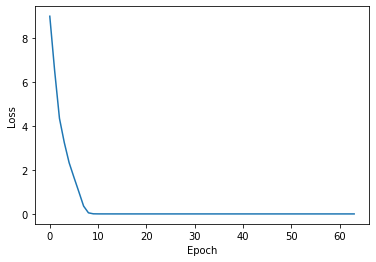

In [23]:
import matplotlib.pyplot as plt
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.grid()
plt.plot(train_loss_hist)

# Evaluation helper funcs

In [13]:
# Edward: note this makes a new caption as (<S>, 0, ..., 0) shouldn't we want as (<S>, <S>, ..., <S>)?
def create_caption_and_mask(start_token, max_length):
    caption_template = torch.zeros((1, max_length), dtype=torch.long)
    mask_template = torch.ones((1, max_length), dtype=torch.bool)

    caption_template[:, 0] = start_token
    mask_template[:, 0] = False

    return caption_template, mask_template

In [14]:
def make_report(captions):
    all_reports = []
    for report in captions:
        if (report == word2ind["</s>"]).any():
            end_index = (report == word2ind["</s>"]).nonzero()[0][0]
            report = report[:end_index+1]
        one_report = list(map(lambda x: ind2word[str(x)], report))
        all_reports.append(one_report)
    return all_reports

def reports_to_sentence(reports):
    return [' '.join(r) for r in make_report(reports)]

In [15]:
def evaluate(images):
    all_captions = []
    model.eval()
    for i in range(len(images)):
        image = images[i:i+1]
        caption, cap_mask = create_caption_and_mask(
            config.pad_token_id, config.max_position_embeddings)
        for i in range(config.max_position_embeddings - 1):
            predictions = model(image, caption, cap_mask)
            predictions = predictions[:, i, :]
            predicted_id = torch.argmax(predictions, axis=-1)


            caption[:, i+1] = predicted_id[0]
            cap_mask[:, i+1] = False
            
            if predicted_id[0] == word2ind["</s>"]:
                break

        all_captions.append(caption.numpy())
#     return make_report(all_captions)
    return all_captions

In [16]:
image, image_mask, note, note_mask = next(iter(data_loader_train))

In [18]:
report = evaluate(image[0:1])

In [19]:
report_np = np.asarray(report).squeeze(1)
reports_to_sentence(report_np)

['<S> There is no focal consolidation , pleural effusion or pneumothorax . <s> Bilateral nodular opacities that most likely represent nipple shadows . <s> The cardiomediastinal silhouette is normal . <s> Clips project over the left lung , potentially within the breast . <s> The imaged upper abdomen is unremarkable . <s> Chronic deformity of the posterior left sixth and seventh ribs are noted . <s> </s>']

In [24]:
reports_to_sentence(np.asarray(note))

['<S> There is no focal consolidation , pleural effusion or pneumothorax . <s> Bilateral nodular opacities that most likely represent nipple shadows . <s> The cardiomediastinal silhouette is normal . <s> Clips project over the left lung , potentially within the breast . <s> The imaged upper abdomen is unremarkable . <s> Chronic deformity of the posterior left sixth and seventh ribs are noted . <s> </s>',
 '<S> There is no focal consolidation , pleural effusion or pneumothorax . <s> Bilateral nodular opacities that most likely represent nipple shadows . <s> The cardiomediastinal silhouette is normal . <s> Clips project over the left lung , potentially within the breast . <s> The imaged upper abdomen is unremarkable . <s> Chronic deformity of the posterior left sixth and seventh ribs are noted . <s> </s>',
 '<S> There is no focal consolidation , pleural effusion or pneumothorax . <s> Bilateral nodular opacities that most likely represent nipple shadows . <s> The cardiomediastinal silhoue

In [58]:
note.shape

torch.Size([8, 129])

In [23]:
evaluate(image[0].unsqueeze(0).unsqueeze(0))

['<S> THE AND LATERAL VIEWS OF THE CHEST . <S> THE AND IS IS IS IS . <S> THE IS THE THE . <S> THE IS IS IS IS IS IS ARE . <S> THE IS IS IS IS IS IS . <S> THE IS IS THE IS IS . <S> </S> " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " " "']

In [64]:
image.unsqueeze(0).shape

torch.Size([1, 8, 1024, 8, 8])